# Support Points and Privacy

_____

In [1]:
# Toggle which experiments to run.
DO_EXPERIMENT_supportpoints = 1 
DO_EXPERIMENT_tensorflow = 0
DO_EXPERIMENT_cdf2pdf = 0

## PART 1: 
## Empirical distance between support points Y and leave-one-out \[LOO\] support points (Y')

"""
Computes max discrepancy of support points due to single-point omission.

For data X, and support points Y:
M(X, m) --> Y
M(X', m) --> Y'
Compute Pr(d(Y, Y') > eps) < delta

let eps = (1-delta)th percentile of max_discrepancies
"""


In [2]:
%matplotlib inline

import argparse
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import os
import pdb
import sys
import time
import tensorflow as tf

from scipy.stats import ks_2samp

In [3]:
m = 10
all_but_one = np.concatenate((10 * np.ones(1), np.random.normal(0, 1, m - 1)))  # "All-but-one" distribution

def sample_gaussian(m):
    mean, loc = 0, 1
    if m == 1:
        return np.random.normal(mean, loc, m)
    else:
        return np.concatenate((10 * np.ones(1), np.random.normal(0, 0.1, m - 1)))  # "All-but-one" distribution
        #return np.random.normal(mean, loc, m)
    
def sample_gamma(m):
    k, theta = 1, 10
    return np.random.gamma(k, theta, m)

In [4]:
def energy(data, gen, sigma=1., unitize_grads=False):
    '''Computes abbreviated energy statistic between two point sets.
    
    The smaller the value, the closer the sets.
    Args:
      data: 1D numpy array of any length, e.g. 100.
      gen: 1D numpy array of any length, e.g. 10.
      sigma: Float, kernel lengthscale.
      unitize_grads: Boolean, divide gradients by norm.
    Returns:
      e: Scalar, the energy between the sets.
      mmd: Scalar, the mmd between the sets.
      gradients_e: Numpy array of energy gradients for each proposal point.
      gradients_mmd: Numpy array of mmdgradients for each proposal point.
    '''
    x = sorted(list(data))
    y = sorted(list(gen))
    data_num = len(x)
    gen_num = len(y)
    num_combos_xx = data_num * (data_num - 1) / 2.
    num_combos_yy = gen_num * (gen_num - 1) / 2.


    # Compute energy.
    v = np.concatenate((x, y), 0)
    v_vert = v.reshape(-1, 1)
    v_tiled = np.tile(v_vert, (1, len(v)))
    pairwise_difs = v_tiled - np.transpose(v_tiled)
    energy = abs(pairwise_difs)
    energy_xx = energy[:data_num, :data_num]
    energy_yy = energy[data_num:, data_num:]
    energy_yx = energy[data_num:, :data_num]
    e = (2. / gen_num / data_num * np.sum(energy_yx) -
         1. / data_num / data_num * np.sum(energy_xx) -
         1. / gen_num / gen_num * np.sum(energy_yy))

    """
    # Compute MMD.
    pairwise_prods = np.matmul(v_vert, np.transpose(v_vert))
    sqs_vert = np.reshape(np.diag(pairwise_prods), [-1, 1])
    sqs_vert_tiled_horiz = np.tile(sqs_vert, (1, data_num + gen_num))
    exp_object = (sqs_vert_tiled_horiz - 2 * pairwise_prods +
                  np.transpose(sqs_vert_tiled_horiz))
    
    K = np.exp(-0.5 / sigma * exp_object)
    K_xx = K[:data_num, :data_num]
    K_yy = K[data_num:, data_num:]
    K_xy = K[:data_num, data_num:]
    K_xx_upper = np.triu(K_xx, 1)
    K_yy_upper = np.triu(K_yy, 1)
    mmd = (1. / num_combos_xx * np.sum(K_xx_upper) +
           1. / num_combos_yy * np.sum(K_yy_upper) -
           2. / data_num / gen_num * np.sum(K_xy))
    """

    # Compute energy gradients.
    # TODO: CHECK WHETHER THIS GRADIENT IS CORRECT.
    signed = np.sign(pairwise_difs)
    signed_yx = signed[data_num:, :data_num]
    signed_yy = signed[data_num:, data_num:]
    gradients_e = []
    for i in range(gen_num):
        grad_yi = (2. / gen_num / data_num * sum(signed_yx[i]) - 
                   2. / gen_num / gen_num * sum(signed_yy[i]))
        gradients_e.append(grad_yi)
    gradients_e[0] *= 2
    gradients_e[-1] *= 2
    
    """
    # Compute MMD gradients.
    mmd_grad = K * (-1. / sigma * pairwise_difs)
    mmd_grad_yx = mmd_grad[data_num:, :data_num] 
    mmd_grad_yy = mmd_grad[data_num:, data_num:] 
    mmd_grad_yy_upper = np.triu(mmd_grad_yy, 1)
    gradients_mmd = []
    for i in range(gen_num):
        grad_yi = (1. / num_combos_yy * 
                       (sum(mmd_grad_yy_upper[i]) -
                        sum(mmd_grad_yy_upper[:, i])) -
                   2. / gen_num / data_num * sum(mmd_grad_yx[i]))
                   
        gradients_mmd.append(grad_yi)
    """
    if unitize_grads:
        gradients_e /= np.linalg.norm(gradients_e) + 1e-6

    return e, np.array(gradients_e)

In [5]:
def optimize(data, gen, max_iter=500, learning_rate=1e-2):
    '''Runs alternating optimizations, n times through proposal points.
    Args:
      data: 1D numpy array of any length, e.g. 100.
      gen: 1D numpy array of any length, e.g. 10.
      max_iter: Scalar, number of times to loop through updates for all vars.
      learning_rate: Scalar, amount to move point with each gradient update.
      
    Returns:
      y_out: 2D numpy array of trace of generated proposal points.
      e_out: Float, energy between data and last iteration of y_out.
    '''
    stability_count = 0
    stability_period = 50
    stability_stopping_criterion = 1e-5

    y_out = np.zeros((max_iter, len(gen)))
    max_grad = np.zeros(max_iter)
    
    # Run optimization steps.
    for it in range(max_iter):
        e_out, e_grads = energy(data, gen)
        gen -= learning_rate * e_grads
        y_out[it, :] = gen
        max_grad[it] = np.max(np.abs(e_grads))
        
        # Early stopping criterion.
        #if it > stability_period and it % stability_period == 0:
        if it in [2, 4, 6, 8, 10, 1000]:
            # Measure stability.
            start_index = np.max((0, it - stability_period))            
            moving_var_max_grad = np.var(max_grad[start_index:it])
            #moving_var = np.max(np.var(y_out[start_index:it, :], axis=0))
            
            #if moving_var < stability_stopping_criterion:
            #    break
            
            #print('it: {}, grads: {}, moving_var_max_grad: {:.3f}'.format(
            #    it,
            #    np.sort(np.abs(e_grads))[-5:],
            #    moving_var_max_grad))

    return y_out[:it], e_out

In [6]:
def plot_single_run(y_out, e_out, p, num_support,
                    percentiles=None):
    data_markers_x = [y_out.shape[0]] * len(p)
    data_markers_y = p
    plt.scatter(data_markers_x, data_markers_y, marker='x', label='data')
    plt.plot(y_out, 'k-', alpha=0.3)
    if percentiles is not None:
        plt.scatter([1.05 * y_out.shape[0]] * y_out.shape[1],
                    percentiles, color='blue', label='pct')
    plt.legend(loc='upper left')
    plt.title('|data|=m={}, |support|=n={}, e(x,y)={:.4f}'.format(
              len(p), num_support, e_out))
    plt.savefig('support_points_path.png');
    plt.show()

In [7]:
def contained_within(a, b, eps=1e-1):
    """Checks if a is contained within b.
       Arguments are 1d arrays. 
    """
    condition1 = np.min(a) >= np.min(b) - eps
    condition2 = np.max(a) <= np.max(b) + eps
    valid = condition1 and condition2
    if not condition1:
        print('condition1: not {} >= {}'.format(np.min(a), np.min(b) - eps))
    if not condition2:
        print('condition2: not {} <= {}'.format(np.max(a), np.max(b) + eps))
    return valid

In [8]:
def get_support_points(data, num_support, max_iter, lr, percentiles, plot=False):
    # Initialize generated particles for both sets (y and y_).
    x = data
    x_range = max(x) - min(x)
    y_orig_offset = x_range * 0.01
    y = list(np.linspace(min(x) + y_orig_offset,
                         max(x) - y_orig_offset,
                         num_support))

    all_but_one = 1
    if all_but_one:
        x_range = max(x[1:]) - min(x[1:])
        y_orig_offset = x_range * 0.01
        y_no10 = list(np.linspace(min(x[1:]) + y_orig_offset,
                             max(x[1:]) - y_orig_offset,
                             num_support - 1))
        y = np.concatenate(([10], y_no10))
        
    #y = percentiles
   
    # Optimize particles for each dataset (x0 and x1).
    y_out, e_out = optimize(x, y, max_iter=max_iter, learning_rate=lr)
    lr_updated = lr
    max_iter_updated = max_iter
    
    # ADJUSTMENT CRITERIA.
    # desirable behavior.
    # if x contains 10:
    #   if n < N/2:
    #     while y not contained within x: reduce lr.
    #     while y not contained within x[1:], increase max_iter.
    #   elif n >= N/2:
    #     while y not contained within x, reduce lr.
    # else:
    #   change starting support point set to not include 10
    #   while y not contained within x, reduce lr.

    if 10 in x
        if num_support <= len(x) / 2.:  # All support points should be within
            while not contained_within(y_out, x):  # within 10
                # Reduce lr and try again.
                lr_updated *= 0.5
                print('Retrying with lr = {}'.format(lr_updated))
                y_out, e_out = optimize(x, y, max_iter=max_iter, learning_rate=lr_updated)
            print('Satisfied "within 10" with lr={}'.format(lr_updated))      
                
            while not contained_within(y_out[0], x[1:]):  # within core
                # Increase max_iter.
                max_iter_updated *= 2
                y_out, e_out = optimize(x, y, max_iter=max_iter_updated, learning_rate=lr_updated)
                
    elif (10 in x) and (num_support >= len(x) / 2.):
        while not contained_within(y_out[-1], x):
            # Reduce lr and try again.
            lr_updated *= 0.5
            y_out, e_out = optimize(x, y, max_iter=max_iter, learning_rate=lr_updated)
            print('Retrying with lr = {}'.format(lr_updated))
        
    elif 10 not in x:
        while not contained_within(y_out[-1], x):  # within core
            # Increase max_iter.
            max_iter_updated *= 2
            y_out, e_out = optimize(x, y, max_iter=max_iter_updated, learning_rate=lr_updated)
        
    print('RESOLVED within x')
    plot_single_run(y_out, e_out, x, num_support)
    
    ############################



    # Get last updated set as support points.
    sp = y_out[-1]
    
    # Plot optimization.
    if plot:
        plot_single_run(y_out, e_out, x, num_support,
                        percentiles=percentiles)
        
    return sp

In [9]:
def measure_eps(discrepancies_hist, discrepancies_cdf, delta):
    eps = np.percentile(discrepancies_hist, 100*(1 - delta))
    print('\nPr(d_hist(Y, Y\') > {:.2f}) < {:.2f}'.format(eps, delta))
    eps = np.percentile(discrepancies_cdf, 100*(1 - delta))
    print('\nPr(d(Y, Y\') > {:.2f}) < {:.2f}'.format(eps, delta))

In [10]:
def eval_with_baseline(data_source, max_discs_shift_y_y_, max_discs_hist_y_y_,
                       max_discs_y_y_, max_discs_x_y_, min_pstats_x_y_, n, m):
    """Shows how well support points fit true distribution.
    
    Compares X_n and Y_n' to distribution X.
    
    Args:
      data_source: String, indicates which distribution to sample.
      max_discs_shift_y_y_: Array, privacy discrepancies (shift).
      max_discs_hist_y_y_: Array, privacy discrepancies (pdf).
      max_discs_y_y_: Array, privacy discrepancies (cdf).
      max_discs_x_y_: Array, utility discrepancies.
      min_pstats_x_y_: Array, utility KS p-statistics.
      m: Int, number of points from reference distribution.
      n: Int, number of points from testing distribution.
    """
    if data_source == 'gaussian':
        sample = sample_gaussian
    elif data_source == 'gamma':
        sample = sample_gamma
    
    # Get discs for X (n samples) and Xm (m samples).
    num_trials = len(max_discs_x_y_)
    discs_x_xn, pstats_x_xn = (
        zip(*(ks_2samp(sample(m), sample(n)) for _ in range(num_trials))))
    
    # Compare discrepancies.
    plt.hist([max_discs_y_y_, max_discs_x_y_, discs_x_xn], histtype='bar',
             bins=20, label=['d(Y, Y\')', 'd(X, Y\')', 'd(X, X_n)'],
             color=['green', 'blue', 'gray'], alpha=0.3)
    plt.title('Baseline comparison: KS distances')
    plt.legend()
    plt.show()
    
    # Compare p-statistics of Y_n' and X_n, each to X.
    plt.hist([pstats_x_xn, min_pstats_x_y_], bins=20,
             label=['Xn diff from X?', 'Y\' diff from X?'],
             color=['blue', 'green'], alpha=0.3)
    plt.title('Baseline comparison: KS p-stats')
    plt.legend()
    plt.show()
    
    tail = 5
    print('max_discs_shift_y_y_: {}'.format(np.round(sorted(max_discs_shift_y_y_), 3)[-tail:]))
    print('max_discs_hist_y_y_: {}'.format(np.round(sorted(max_discs_hist_y_y_), 3)[-tail:]))
    print('max_discs_y_y_: {}'.format(np.round(sorted(max_discs_y_y_), 3)[-tail:]))
    print('max_discs_x_y_: {}'.format(np.round(sorted(max_discs_x_y_), 3)[-tail:]))
    print('max_discs_x_xn_: {}'.format(np.round(sorted(discs_x_xn), 3)[-tail:]))
    
    print('min_pstats_x_xn: {}'.format(np.round(sorted(pstats_x_xn), 3)[:tail]))
    print('min_pstats_x_y_: {}'.format(np.round(sorted(min_pstats_x_y_), 3)[:tail]))

In [11]:
def middle_n_percentiles(x, n): 
    return np.percentile(x, np.linspace(1./(n+1), 1 - 1./(n+1), n) * 100)

In [12]:
def run_trial(data_source, m, n, max_iter, lr, plot=False, single_run=False):
    """Finds support point discrepancies due to single-point omission.
    
    Args:
      data_source: String, identifier for dataset to use.
      m: Int, number of data points in X. So X' has n-1.
      n: Int, number of support points in Y and Y'.
      max_iter: Number of iterations in support point optimization.
      lr: Float, learning rate for energy optimization.
    """
    # Collect outputs for Y and Y', and for X and Y'.
    discs_shift_y_y_ = []
    discs_hist_y_y_ = []
    discs_y_y_ = []
    discs_x_y_ = []
    pstats_x_y_ = []
    
    # Sample n from reference distribution.
    if data_source == 'gaussian':
        x = sample_gaussian(m)
    elif data_source == 'gamma':
        x = sample_gamma(m)
    else:
        print('Set up fn for unknown data_source')
        sys.exit()

    # Compute m support points on full set.
    percentiles = middle_n_percentiles(x, n)

    y = get_support_points(x, n, max_iter, lr, percentiles, plot=plot)
    #y = percentiles

    dist_maxSP_n1data = max(y) - max(x[1:])
    
    # Compare support points on full set vs single-point omission set.
    #for removed_index in range(m):
    for removed_index in [0]:

        # Remove the current index to make the "neighboring" set.
        x_ = [v for i,v in enumerate(x) if i != removed_index]
        #x_ = [v if i != removed_index else sample_gaussian(1)[0] for i,v in enumerate(x)]

        # Compute reduced set representation, i.e. support points or percentiles.
        percentiles = middle_n_percentiles(x_, n)

        y_ = get_support_points(x_, n, max_iter, lr, percentiles, plot=plot)
        #y_ = percentiles_
        
        
        # ----------------------
        # Compute Discrepancies.
        # ----------------------
        # Get distance between full-set and single-point omission support points.
        disc_y_y_, _ = ks_2samp(y, y_)
        disc_x_y_, pstat_x_y_ = ks_2samp(x, y_)
        
        # Get maximal difference in histogram density between y and y_.
        min_y = np.min(np.concatenate((y, y_)))
        max_y = np.max(np.concatenate((y, y_)))
        h_y = np.histogram(y, bins=np.linspace(min_y, max_y, n), density=True)
        h_y_ = np.histogram(y_, bins=np.linspace(min_y, max_y, n), density=True)
        disc_hist_y_y_ = np.max(np.abs(h_y[0] - h_y_[0]))
        
        # Get maximal shift in support points.
        disc_shift_y_y_ = np.max(np.abs(np.sort(y) - np.sort(y_)))
        
        # ----------------------
        
        
        # Add results to list for this sample x.
        discs_shift_y_y_.append(disc_shift_y_y_)
        discs_hist_y_y_.append(disc_hist_y_y_)
        discs_y_y_.append(disc_y_y_)
        discs_x_y_.append(disc_x_y_)
        pstats_x_y_.append(pstat_x_y_)
        
        plot_verbose = 0
        if plot_verbose:
            # Hist of PDFs.
            plt.hist([y, y_], bins=20, label=['y', 'y_'], density=True)
            plt.title('PDFs max_density_dif(Ym, Ym_) = {:.3f}'.format(disc_hist_y_y_))
            plt.show()
            
            # eCDF of Y and Y'.
            plt.scatter(x[removed_index], 0.0, label='pt removed')
            plt.step(np.sort(y), np.arange(1, len(y) + 1) / float(len(y)),
                     label='y', color='blue', alpha=0.7, where='post')
            plt.step(np.sort(y_), np.arange(1, len(y_) + 1) / float(len(y_)),
                     label='y_', color='green', alpha=0.7, where='post')
            plt.legend()
            plt.ylim((-0.1, 1.1))
            plt.title('CDFs. KS(Ym, Ym_) = {:.3f}'.format(disc_y_y_))
            plt.show()
            
            # eCDF of percentiles and percentiles_.
            plt.scatter(x[removed_index], 0.0, label='pt removed')
            plt.step(percentiles, np.arange(1, len(percentiles) + 1) / float(len(percentiles)),
                     label='pct', color='blue', alpha=0.7, where='post')
            plt.step(percentiles_, np.arange(1, len(percentiles_) + 1) / float(len(percentiles_)),
                     label='pct_', color='green', alpha=0.7, where='post')
            plt.legend()
            plt.ylim((-0.1, 1.1))
            plt.title('CDFs. Percentiles.'.format(disc_y_y_))
            plt.show()
            
            # eCDF of X and Y'.
            plt.scatter(x[removed_index], 0.0, label='pt removed')
            plt.step(np.sort(x), np.arange(1, len(x) + 1) / float(len(x)),
                     label='x', color='gray', alpha=0.5, where='post')
            plt.step(np.sort(y_), np.arange(1, len(y_) + 1) / float(len(y_)),
                     label='y_', color='green', alpha=0.7, where='post')
            plt.legend()
            plt.ylim((-0.1, 1.1))
            plt.title('CDFs. KS(Xn, Ym_) = {:.3f}'.format(disc_x_y_))
            plt.show()

            print('x: {}'.format(np.round(sorted(x), 2)))
            print('y: {}'.format(np.round(sorted(y), 2)))
            print('y_: {}'.format(np.round(sorted(y_), 2)))

        if single_run:
            break

    # Compute max shift, add associated noise to support points,
    # sample from kernels centered at noised support points,
    # measure accuracy (x, y), measure accuracy (x, g(y^))
    max_shift = np.max(discs_shift_y_y_)
    y_noisy = [i + np.random.laplace(max_shift) for i in y]
    x_noisy = [np.random.laplace(np.random.choice(y), max_shift) for _ in x]
    disc_x_x_noisy, _ = energy(x, x_noisy)
    disc_x_y_noisy, _ = energy(x, y_noisy)
    disc_x_y, _ = energy(x, y)
    if plot:
        plt.hist(x, bins=20, alpha=0.3, label='x', density=True)
        plt.hist(x_noisy, bins=20, alpha=0.3, label='x_noisy', density=True)
        plt.title('disc_x_x_noisy: {:.3f}'.format(disc_x_x_noisy))
        plt.legend()
        plt.show()
    
    return (dist_maxSP_n1data, discs_shift_y_y_, discs_hist_y_y_, discs_y_y_, 
            discs_x_y_, pstats_x_y_, disc_x_x_noisy, disc_x_y_noisy, disc_x_y)

## Run support point vs. LOO support point experiment.

In [13]:
def run_trials_mn(m, n, num_trials, lr, max_iter):
    delta = 1. / m  # Probability of exposing a single point.
    data_source = 'gaussian'

    # Run trials.
    dists_maxSP_n1data = []
    max_discs_shift_y_y_ = []
    max_discs_hist_y_y_ = []
    max_discs_y_y_ = []
    max_discs_x_y_ = []
    min_pstats_x_y_ = []
    discs_x_x_noisy = []
    discs_x_y_noisy = []
    discs_x_y = []

    start_time =  time.time()
    for i in range(num_trials):
        if i % 10 == 0:
            print('Run {}'.format(i))
    
        # Get discrepancies for privacy and utility pairs.
        plot = True if i == 0 else False  # Plot only on first exp.
        #plot = True

        # Runs trial for one sample X, and all LOO Y's.
        (dist_maxSP_n1data,
         discs_shift_y_y_,
         discs_hist_y_y_,
         discs_y_y_,
         discs_x_y_,
         pstats_x_y_,
         disc_x_x_noisy,
         disc_x_y_noisy,
         disc_x_y) = run_trial(data_source, m, n, max_iter, lr, plot=plot, single_run=True)

        dists_maxSP_n1data.append(dist_maxSP_n1data)
        max_discs_shift_y_y_.append(np.max(discs_shift_y_y_))
        max_discs_hist_y_y_.append(np.max(discs_hist_y_y_))
        max_discs_y_y_.append(np.max(discs_y_y_))
        max_discs_x_y_.append(np.max(discs_x_y_))
        min_pstats_x_y_.append(np.min(pstats_x_y_))
        discs_x_x_noisy.append(disc_x_x_noisy)
        discs_x_y_noisy.append(disc_x_y_noisy)
        discs_x_y.append(disc_x_y)        
    
    return max_discs_shift_y_y_, discs_x_x_noisy, dists_maxSP_n1data
    
    """
    # Utility: How does Y_m' compare to X_m, in belonging to X? 
    eval_with_baseline(data_source, max_discs_shift_y_y_, 
                       max_discs_hist_y_y_, max_discs_y_y_,
                       max_discs_x_y_, min_pstats_x_y_, m, n)
    
    # Privacy: How close is Y_m' to Y_m?
    measure_eps(max_discs_hist_y_y_, max_discs_y_y_, delta)
    
    end_time = time.time()
    print('Time elapsed: {:.1f}s'.format(end_time - start_time))
    """

Run 0


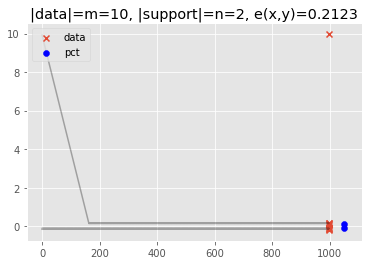

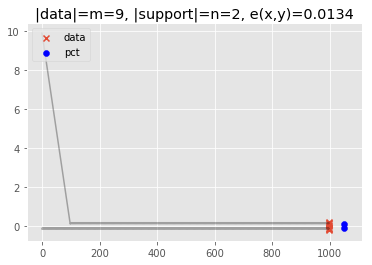

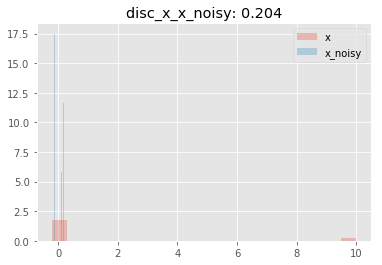

Run 10
Run 20
Run 30
Run 40
m: 10, n: 2, max_shift: 0.060, disc_x_x_noisy: 0.211, dist_maxSP_n1data: -0.047
Run 0


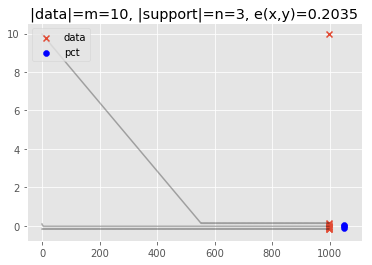

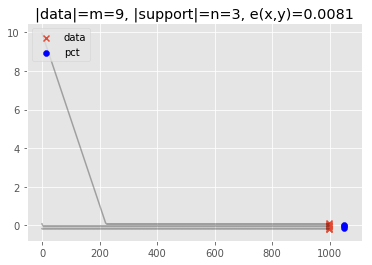

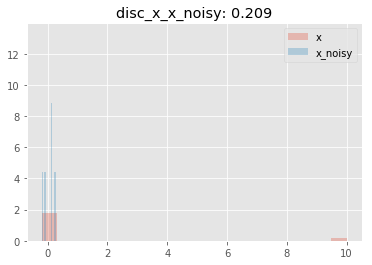

Run 10
Run 20
Run 30
Run 40
m: 10, n: 3, max_shift: 0.052, disc_x_x_noisy: 0.209, dist_maxSP_n1data: -0.003
Run 0


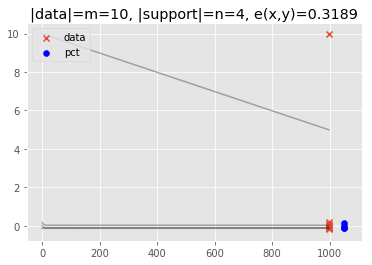

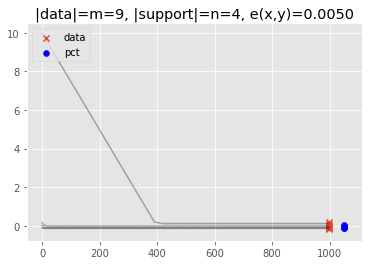

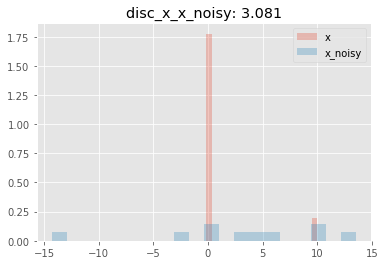

Run 10
Run 20
Run 30
Run 40
m: 10, n: 4, max_shift: 4.881, disc_x_x_noisy: 2.412, dist_maxSP_n1data: 4.835
Run 0


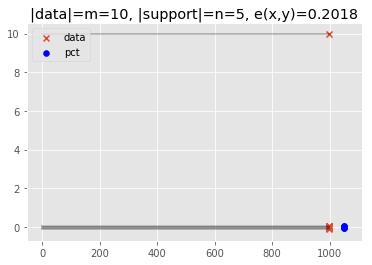

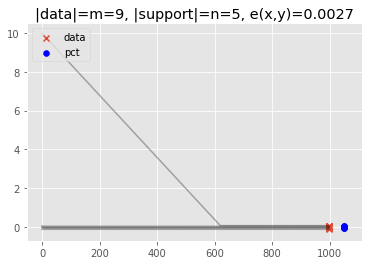

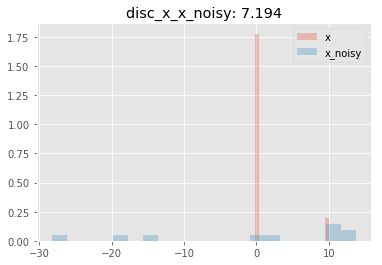

Run 10
Run 20
Run 30
Run 40


KeyboardInterrupt: 

In [14]:
if DO_EXPERIMENT_supportpoints:
    if 0:
        m, n = 10, 7
        out, _, _ = run_trials_mn(m, n, num_trials)
        print('m: {}, n: {}, max_shift: {:.6f}'.format(m, n, out[0]))
        pdb.set_trace()
    
    
    #############################################
    # -------------- main() ------------------
    #############################################
    
    m = 10
    support_point_grid = range(2, m, 1)
    num_trials = 50  # Num times to test each m-n combination.
    max_iter = 1000  # Num iterations in each support point optimization.
    lr = 0.1 # Energy optimization learning rate.
    
    max_shifts_all = np.zeros((len(support_point_grid), num_trials))
    discs_x_x_noisy_all = np.zeros((len(support_point_grid), num_trials))
    dists_maxSP_n1data_all = np.zeros((len(support_point_grid), num_trials))
    
    start_time = time.time()
    
    for i, n in enumerate(support_point_grid):
        (max_shifts_mn,
         discs_x_x_noisy,
         dists_maxSP_n1data) = run_trials_mn(m, n, num_trials, lr, max_iter)
        
        max_shifts_all[i] = max_shifts_mn
        discs_x_x_noisy_all[i] = discs_x_x_noisy
        dists_maxSP_n1data_all[i] = dists_maxSP_n1data
        
        print(('m: {}, n: {}, max_shift: {:.3f}, disc_x_x_noisy: {:.3f}, '
               'dist_maxSP_n1data: {:.3f}').format(
            m, n, np.median(max_shifts_mn), np.median(discs_x_x_noisy),
            np.median(dists_maxSP_n1data)))

    end_time = time.time()
    print('Time elapsed: {:.1f}s'.format(end_time - start_time))
    
    # Plot results.
    plt.plot(support_point_grid, np.median(max_shifts_all, axis=1))
    plt.xlabel('num support points')
    plt.ylabel('median of max_shifts over trials')
    plt.show()
    plt.plot(support_point_grid, np.median(discs_x_x_noisy_all, axis=1))
    plt.xlabel('num support points')
    plt.ylabel('median of disc_x_x_noisy over trials')
    plt.show()
    plt.plot(support_point_grid, np.median(dists_maxSP_n1data_all, axis=1))
    plt.xlabel('num support points')
    plt.ylabel('median of dist_maxSP_n1data_all over trials')
    plt.show()
    
    print(np.min(dists_maxSP_n1data_all, axis=1))

    pdb.set_trace()

____

## PART 2:
## TensorFlow attack. Identify missing Xi.

#### Build the training set of datasets and their support points.

In [ ]:
import numpy as np

def build_nn_training_set(CONFIG):
    n = CONFIG['energy_n']
    m = CONFIG['energy_m']
    lr = CONFIG['energy_lr']
    max_iter = CONFIG['energy_max_iter']
    data_source = CONFIG['data_source']
    data_size = CONFIG['tf_data_size']
    
    assert data_source == 'gaussian', 'Temporarily only Gaussian(0,1)'
    
    data = np.zeros((data_size, n + m + 1))  # Add one for removed index.
    for i in range(data_size):
        x = np.random.normal(0, 1, size=n)
        removed_index = np.random.choice(range(n))
        x_ = [v for i,v in enumerate(x) if i != removed_index]
        percentiles = middle_n_percentiles(x_, n)

        y_ = get_support_points(x_, m, max_iter, lr, percentiles)
        
        # Assemble example with original data, LOO support points,
        # and removed index.
        data[i] = np.concatenate((np.sort(x), np.sort(y_), [removed_index]))
    
    dim_x, dim_y = n, m
    data_train = data[:int(0.8 * data.shape[0])]
    data_test = data[int(0.8 * data.shape[0]):]
    
    np.save('nn_training_set.npy', data_train)
    return data_train, data_test, dim_x, dim_y

#### Build the TF graph and train.

In [ ]:
def run_tf(CONFIG, data_train, data_test):
    import tensorflow as tf
    tf.reset_default_graph()
    
    width = CONFIG['tf_width']
    depth = CONFIG['tf_depth']
    lr = CONFIG['tf_lr']
    max_iter = CONFIG['tf_max_iter']
    activation = CONFIG['tf_activation']
    regularizer = CONFIG['tf_regularizer']

    # Set up config for neural network.
    data_train_inputs, data_train_labels = data_train[:,:-1], data_train[:,-1]
    data_test_inputs, data_test_labels = data_test[:,:-1], data_test[:,-1]
    n_inputs = data_train_inputs.shape[0]


    ###############
    # Build graph.

    # Computation.
    input_data = tf.placeholder(tf.float32, [None, dim_x + dim_y], name='input_data')
    input_labels = tf.placeholder(tf.int32, [None], name='input_labels')
    labels = tf.one_hot(input_labels, dim_x)

    h = input_data
    for d in range(depth):
        h = tf.layers.dense(h, width, activation=activation,
                            activity_regularizer=regularizer)
        h = tf.nn.dropout(h, 0.8)
    logits = tf.layers.dense(h, dim_x)

    # Loss and optimization.
    loss = tf.reduce_mean(
        tf.losses.softmax_cross_entropy(labels, logits))
    opt = tf.train.RMSPropOptimizer(lr)
    grads_, vars_ = zip(*opt.compute_gradients(
        loss,var_list=tf.trainable_variables()))
    grads_clipped_ = tuple([tf.clip_by_value(g, -0.01, 0.01) for g in grads_])
    optim = opt.apply_gradients(zip(grads_clipped_, vars_))

    # Performance.
    prediction = tf.nn.softmax(logits)
    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    #############

    # Train.
    init_op = tf.global_variables_initializer()
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
    sess_config = tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options)
    with tf.Session(config=sess_config) as sess:
        sess.run(init_op)

        for i in range(max_iter):
            acc_train_, loss_, _ = sess.run([accuracy, loss, optim], 
                                {input_data: data_train_inputs,
                                 input_labels: data_train_labels})

            if i % 1000 == 0:
                acc_test_ = sess.run(accuracy, 
                                     {input_data: data_test_inputs,
                                      input_labels: data_test_labels})

                print(('Iter: {}. , Loss={:.3f}, Acc_train={:.3f}, '
                       'Acc_test={:.3f}').format(i, loss_, acc_train_, acc_test_))

In [ ]:
CONFIG = {
    'energy_m': 50,
    'energy_n': 10,
    'energy_lr': 1.,
    'energy_max_iter': 100,
    'data_source': 'gaussian',
    'tf_data_size': 250,
    'tf_lr': 1e-4,
    'tf_max_iter': 500000,
    'tf_activation': tf.nn.relu,
    'tf_regularizer': None, #tf.contrib.layers.l1_regularizer(0.001),
    'tf_width': 100,
    'tf_depth': 5,
}

In [ ]:
if DO_EXPERIMENT_tensorflow:
    print('\n\nTrial run for support points. Check for convergence before proceeding.')
    run_trial(CONFIG['data_source'], CONFIG['energy_m'], CONFIG['energy_n'],
              CONFIG['energy_max_iter'], plot=True)
    
    print('\n\n[Generating training data for TensorFlow prediction model.]')
    data_train, data_test, dim_x, dim_y = build_nn_training_set(CONFIG)
    
    print('\n\nTraining TensorFlow prediction model.')
    run_tf(CONFIG, data_train, data_test)

# PART 3

In [ ]:
if DO_EXPERIMENT_cdf2pdf:
    import numpy as np
    import matplotlib.pyplot as plt
    plt.style.use('ggplot')
    scale = 0.

    # Histograms.
    x = np.random.normal(0, 1, size=20)
    y = np.copy(x)
    y[np.where(np.abs(x) < 1)] *= scale
    plt.hist([x, y], bins=20, alpha=0.3, label=['x', 'y'])
    #plt.hist(y, bins=10, alpha=0.3, label='y')
    plt.legend()
    plt.show()

    # eCDFs
    plt.step(np.sort(x), np.arange(1, len(x) + 1) / float(len(x)),
             label='cdf', color='red', alpha=0.7, where='post')
    plt.step(np.sort(y), np.arange(1, len(y) + 1) / float(len(y)),
             label='cdf', color='blue', alpha=0.7, where='post')
    plt.legend()
    plt.ylim((-0.1, 1.1))
    plt.title('CDFs')
    plt.show()